In [1]:
import matplotlib.pyplot as plt
import random

import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import datasets


In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                                         n_classes = 2, n_redundant=0, 
                                                                         n_clusters_per_class=1, random_state=15)

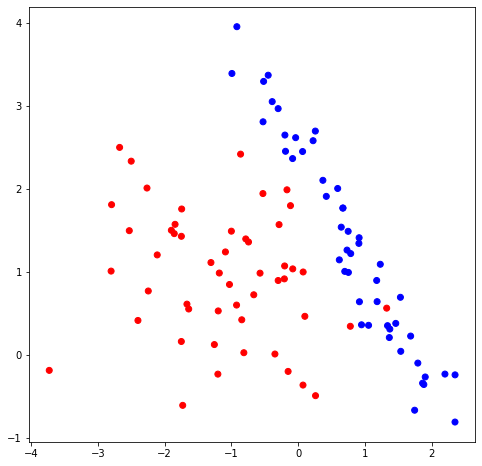

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x : x[0], classification_data)), list(map(lambda x : x[1], classification_data)),
           c=classification_labels, cmap=colors);

In [48]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch   # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        

In [49]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}   # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
         #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction
        

In [50]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    #  расчет критерия
    impurity = 1 
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [51]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):
    
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [52]:
# Разбиение датасета в узле

def split(data, labels,  index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [53]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 10
    
    current_gini = gini(labels)
    
    best_quality = 0 
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_value = np.unique([row[index] for row in data])
        
        for t in t_value:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 10 объектов
            
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
                
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                
    return best_quality, best_t, best_index

In [54]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):
    
    quality, t, index = find_best_split(data, labels)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [55]:
def classify_object(obj, node):
    
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
         return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [56]:
def predict(data, tree):
    
    classes = []
    
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [57]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, classification_labels,
                                                                                   test_size = 0.3, random_state = 1)

In [58]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [59]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=''):
    
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + 'Прогноз:', node.prediction)
        return
    
    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс:', str(node.index))
    print(spacing + 'Порог:', str(node.t))
    
    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + ' --> True:')
    print_tree(node.true_branch, spacing + ' ')
    
    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + ' --> False:')
    print_tree(node.false_branch, spacing + ' ')
    
print_tree(my_tree)

Индекс: 0
Порог: 0.09910021047912587
 --> True:
 Индекс: 1
 Порог: 2.3333100805879567
  --> True:
  Прогноз: 0
  --> False:
  Прогноз: 1
 --> False:
 Индекс: 0
 Порог: 0.7802286765985396
  --> True:
  Прогноз: 1
  --> False:
  Прогноз: 1


In [60]:
# Получим ответы для обучающей выборки 
train_answer = predict(train_data, my_tree)

In [61]:
# И получим ответы для тестовой выборки
answer = predict(test_data, my_tree)

In [62]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0 
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100

In [63]:
# Точность на обучающей выборке

train_accuracy = accuracy_metric(train_labels, train_answer)
train_accuracy

95.71428571428572

In [64]:
# Точность на тестовой выборке

test_accuracy = accuracy_metric(test_labels, answer)
test_accuracy

93.33333333333333

Text(0.5, 1.0, 'Test accuracy=93.33')

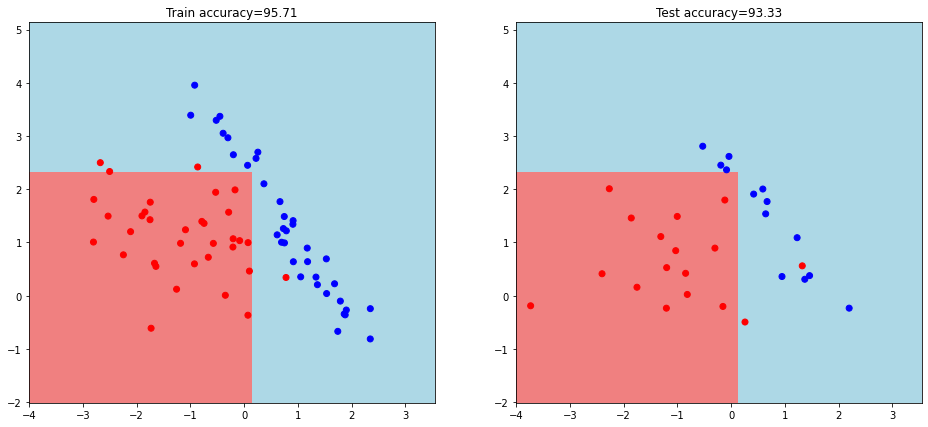

In [65]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

2* Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.


In [178]:
class DecisionTreeRegressor:

    class Node:
    
        def __init__(self, index, threshold, true_branch, false_branch):
            self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.threshold = threshold  # значение порога
            self.true_branch = true_branch   # поддерево, удовлетворяющее условию в узле
            self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
            
    class Leaf:
    
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels
            # берем среднее
            self.prediction = sum(self.labels) / len(labels)
        
    def __init__(self, *, max_depth=None, max_features=None, min_split_gain=None, min_leaf_samples=1):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_split_gain = min_split_gain
        self.min_leaf_samples = min_leaf_samples
        
        self.used_features = set()
        
        self.tree = None
        
    def fit(self, data, labels):
        self.tree = self.build_tree(np.array(data), np.array(labels))
        
    # построим дерево с помощью рекурсивной функции
    def build_tree(self, data, labels, current_depth=0):
        #Прекращаем рекурсию, если достигнута максимальная глубина дерева
        if (self.max_depth is not None) and (current_depth == self.max_depth):
            return Leaf(data, labels)
        
        # Находим наилучшее разбиение данных
        quality, threshold, index = self.find_best_split(data, labels)
        
        #прекращаем рекурсию, когда прироста в качестве нет или он меньше заданного
        if (quality == 0) or ((self.min_split_gain is not None) and (quality < self.min_leaf_samples)):
            return Leaf(data, labels)
        print(quality)
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, threshold)
        
        if index not in self.used_features:
            self.used_features.add(index)
            
        # рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, current_depth + 1)
        false_branch = self.build_tree(false_data, false_labels, current_depth + 1)
        
        # Сохраняем полученное дерево для дальнейших предсказаний
        return Node(index, threshold, true_branch, false_branch)
    
    #нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
        current_variance = self.variance(labels)
        
        best_quality = 0
        best_threshold = None
        best_index = None
        
        n_features = data.shape[1]
        for index in range(n_features):
            #Пропускаем признаки, если достигнуто макс кол-во используемых признаков
            if (self.max_features is not None) and (index not in self.used_features):
                continue
                
            # будем проверять только уникальные значения признака, исключая повторения 
            threshold_values = np.unique(data[:, index])
            
            for threshold in threshold_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, threshold)
                # пропускаем разбиения в которых в узле остается менее минимума объекта
                if min(len(true_data), len(false_data)) < self.min_leaf_samples:
                    continue
                    
                current_quality = self.quality(true_labels, false_labels, current_variance)
                
                # выбираем порог, на котором получается максимальный прирост качества 
                if current_quality > best_quality:
                    best_quality, best_threshold, best_index = current_quality, threshold, index
        return best_quality, best_threshold, best_index
    
    # разбиваем датасет в узле
    def split(self, data, labels, index, threshold):
        true_indexes = np.where(data[:, index] <= threshold)
        false_indexes = np.where(data[:, index] > threshold)
        return data[true_indexes], data[false_indexes], labels[true_indexes], labels[false_indexes]
    
    # Расчет качетсва
    def quality(self, true_labels, false_labels, current_variance):
        #доля выборки, ушедшая в левое поддерево 
        true_prob = float(true_labels.shape[0]) / (true_labels.shape[0] + false_labels.shape[0])
        return current_variance - (true_prob * self.variance(true_labels)) - ((1 - true_prob) * self.variance(false_labels))
    
    # расчет критерия Джини
    def variance(self, labels):
        return (1 / labels.shape[0]) * np.sum((labels - np.mean(labels)) ** 2)
    
    def predict(self, data, tree):
        classes = []
        # классифицируем каждое наблюдение в полученном датасете 
        return np.array([self.classify_object(obj, self.tree) for obj in data])
        
    
    def classify_object(self, obj, node):
        # останавливаем рекурсию если достигли литса
        if isinstance(node, Leaf):
            return node.prediction
        
        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

Сгенерируем данные и проверим модель

In [179]:
data_reg, labels_reg = datasets.make_regression(n_features=2, n_informative = 2,
                                               n_targets = 1, random_state=5)

In [190]:
reg_tree = DecisionTreeRegressor(max_depth=5, min_split_gain=50, min_leaf_samples=3)

In [191]:
reg_tree.fit(data_reg, labels_reg)

2287.2592224630116
939.0818353592983
845.590364571251
138.73379726488838
181.84548507960184
43.04248957272199
200.68570117867233
101.22129042908864
18.619786245825637
165.9871399364257
86.93143943286498
1086.5108363253012
258.87933384551553
107.80212390943841
48.67207659795886
154.5738248097625
35.560637219804924
562.9341798599567
126.59998017054939
61.557479948153414


In [192]:
labels_pred = reg_tree.predict(data_reg, reg_tree)

In [193]:
def mse(y, y_pred):
    return np.sum((y - y_pred) ** 2) / len(y)

In [194]:
mse(labels_reg, labels_pred)

175.10081213265335